# 线性回归的从零开始实现

我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [14]:
%matplotlib inline
import random
import torch
import matplotlib.pyplot as plt
#from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [15]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 生成1000个2维数据（1000*2），每个数值为（0，1）的正态分布，因为参数w是2个维度，所以训练数据也要两个维度
    y = torch.matmul(X, w) + b # 矩阵相乘
    y += torch.normal(0, 0.01, y.shape) #每个y加上一点点噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）

In [16]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.2330, -0.2846]) 
label: tensor([4.7007])


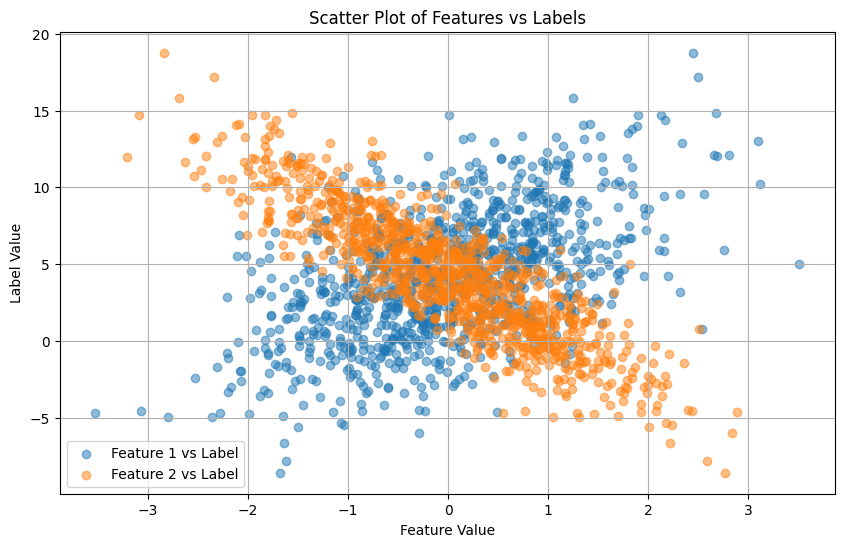

In [17]:
# d2l.set_figsize()
# d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)


# 绘制散点图
plt.figure(figsize=(10, 6))

# 绘制第一个特征与标签的关系
plt.scatter(features[:, 0].numpy(), labels.numpy(), alpha=0.5, label='Feature 1 vs Label')

# 绘制第二个特征与标签的关系
plt.scatter(features[:, 1].numpy(), labels.numpy(), alpha=0.5, label='Feature 2 vs Label')

# 设置图表信息
plt.xlabel('Feature Value')
plt.ylabel('Label Value')
plt.title('Scatter Plot of Features vs Labels')
plt.legend()
plt.grid(True)
plt.show()

定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [25]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

"""
yield 的行为
生成器函数：包含 yield 的函数会返回一个生成器对象（而不是直接返回结果）。
按需计算：生成器不会立即执行函数代码，而是每次调用时返回一个值并暂停函数执行。
恢复执行：当生成器的下一个值被请求时，函数会从上次暂停的地方继续执行。
节省内存：适用于需要逐步返回多个值的大型数据集。
"""
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.4871,  0.4586],
        [-1.4804, -0.2731],
        [ 0.2211,  1.0613],
        [ 1.1080, -0.3938],
        [ 0.5153, -0.4773],
        [-0.3788,  0.9849],
        [ 0.1983, -1.2677],
        [ 0.3666,  0.5409],
        [ 0.2724,  0.1138],
        [-0.5786, -0.0357]]) 
 tensor([[-0.3430],
        [ 2.1761],
        [ 1.0179],
        [ 7.7664],
        [ 6.8449],
        [ 0.0946],
        [ 8.9005],
        [ 3.0977],
        [ 4.3649],
        [ 3.1839]])


在我们开始用小批量随机梯度下降优化我们的模型参数之前
我们需要先有一些参数

In [19]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型，将模型的输入和参数同模型的输出关联起来

In [20]:
def linreg(X, w, b):  
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [21]:
def squared_loss(y_hat, y):  
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [22]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [23]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.028618
epoch 2, loss 0.000099
epoch 3, loss 0.000047


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [24]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0003,  0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([9.0599e-06], grad_fn=<RsubBackward1>)
